In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import h5py
import re
from astropy.time import Time
from matplotlib.colors import LinearSegmentedColormap
from mc3.stats import time_avg


In [2]:
# define a few functions 
# Adapted from SPCA pipeline
def extract_mcmc_parameters(file_path):
    # Read the file content
    with open(file_path, "r") as file:
        data = file.read()
    
    # Extract key-value pairs using regular expressions
    results = re.findall(r'(\S+)\s*=\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*(\+\d*\.?\d+(?:[eE][-+]?\d+)?)?\s*(\-\d*\.?\d+(?:[eE][-+]?\d+)?)?', data)
    
    # Store results in a dictionary
    parameters = {}
    for result in results:
        key = result[0]
        value = float(result[1])
        plus_err = float(result[2]) if result[2] else None
        minus_err = float(result[3]) if result[3] else None
        parameters[key] = {
            "value": value,
            "plus_err": plus_err,
            "minus_err": minus_err
        }
    
    return parameters

text_objects = []
def create_subplot_names(rows, cols, rowslabel=None, minflux=None, maxflux=None, rednoisePlot=False):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(30, len(rows) * 4))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed
    if minflux is not None and maxflux is not None:
        plt.ylim(minflux, maxflux)

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            # ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                if rowslabel==None:
                    ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label
                else:
                    ax.set_ylabel(rowslabel[i], fontsize=20, labelpad=20)  # Row name as y-axis label
            
            # Add "No Model" text to each subplot
            text_obj = ax.text(0.5, 0.45, 'No Model', transform=ax.transAxes,
                             fontsize=18, color='grey', ha='center', va='bottom')  #, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
            text_objects.append(text_obj)

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        if rednoisePlot is True:
            ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
            ax.set_xlabel(col, fontsize=20, labelpad=35)  # Column name as x-axis label         
        else:
            ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
            ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

def calculate_delta_bic(bic_values_dict):
# Get the list of BIC values

    min_bic_key = min(bic_values_dict, key=lambda k: bic_values_dict[k])

    bic_values = list(bic_values_dict.values())
    min_bic = min(bic_values) # Find the minimum BIC value

    # Calculate delta BIC by subtracting the minimum BIC from each BIC value
    delta_bic_values = [bic - min_bic for bic in bic_values]

    # Create a dictionary that maps subplot names to their delta BIC values
    delta_bic_dict = {subplot_name: delta_bic for subplot_name, delta_bic in zip(bic_values_dict.keys(), delta_bic_values)}

    return delta_bic_dict, min_bic_key

def colormap(color=None):
    if color == "rosybrown":
        cmap = LinearSegmentedColormap.from_list('custom_rosybrown', [(0.737, 0.561, 0.561, 0.7), (0.737, 0.561, 0.561, 0)], N=256)
    elif color == "mintgreen":
        cmap = LinearSegmentedColormap.from_list('custom_mintgreen', [(0.678, 0.902, 0.749, 0.8), (0.678, 0.902, 0.749, 0)], N=256)
    elif color == "peach":
        cmap = LinearSegmentedColormap.from_list('custom_peach', [(0.976, 0.729, 0.651, 0.7), (0.976, 0.729, 0.651, 0)], N=256)
    elif color == "macaron_blue":
        cmap = LinearSegmentedColormap.from_list('custom_macaron_blue', [(0.482, 0.686, 0.937, 0.7), (0.482, 0.686, 0.937, 0)], N=256)
    elif color == "amber_orange":
        cmap = LinearSegmentedColormap.from_list('custom_amber_orange', [(1.0, 0.749, 0.0, 0.7), (1.0, 0.749, 0.0, 0)], N=256)
    elif color == "crimson_red":
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.7), (0.863, 0.078, 0.235, 0)], N=256)
    elif color == "dark_teal":
        cmap = LinearSegmentedColormap.from_list('custom_dark_teal', [(0.0, 0.204, 0.204, 0.5), (0.0, 0.204, 0.204, 0)], N=256)
    elif color == "terracotta":
        cmap = LinearSegmentedColormap.from_list('custom_terracotta', [(0.796, 0.388, 0.286, 0.7), (0.796, 0.388, 0.286, 0)], N=256)
    elif color == "muted_lavender":
        cmap = LinearSegmentedColormap.from_list('custom_muted_lavender', [(0.655, 0.529, 0.714, 0.6), (0.655, 0.529, 0.714, 0)], N=256)
    elif color == "yellow":
        cmap = LinearSegmentedColormap.from_list('custom_yellow', [(243/255, 187/255, 70/255, 1.0), (243/255, 187/255, 70/255, 0)], N=256)
    elif color == "blue":
        cmap = LinearSegmentedColormap.from_list('custom_blue', [(0.25, 0.47, 0.75, 0.7), (0.25, 0.47, 0.75, 0)], N=256)

    else:
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.6), (0.863, 0.078, 0.235, 0)], N=256)
    return cmap

def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

def assign_colors_to_bic(bic_values_dict):
    bic_values = list(bic_values_dict.values())

    cmap = colormap(color)

    # Normalize BIC values to [0, 1] for colormap
    norm = plt.Normalize(min(bic_values), max(bic_values))
    
    # Map BIC values to colors
    colors = cmap(norm(bic_values))
    
    # Create a dictionary that maps subplot names to their colors
    bic_colors_dict = {subplot_name: color for subplot_name, color in zip(bic_values_dict.keys(), colors)}
    
    return bic_colors_dict

def plot_model(x, flux, astro, detec, 
               axName=None, bic=None, t_s=None, fp=None,
               savepath='plots/', plotName='Combined_plot_e1.pdf', plotTrueAnomaly=False, nbin=None, background_colors=None, min_subplot=False):   
    
    if nbin is not None:
        x_binned, _ = binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = binValues(flux / detec, x, nbin, assumeWhiteNoise=True)
        #residuals_binned, residuals_binned_err = binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='k', linewidth=2, alpha=0.7, zorder=1)
    # add straight line 
    axes.axhline(y=1, ls='--', color='k', alpha=0.7, zorder=200)
    
    if nbin is not None:
        axes.plot(x_binned, calibrated_binned, '.', color='k', markersize=4, alpha=0.15, zorder=2)
    else:
        axes.plot(x, flux/detec, '.', color='k', markersize=4, alpha=0.15, zorder=2)

    fp, fp_errp, fp_errm = fp

    if bic is not None and min_subplot is False:
        axes.text(0.5, 0.82, r'$\Delta$BIC: {:.2f}'.format(bic), transform=axes.transAxes,
                  fontsize=16, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
        axes.text(
            0.5, 0.64,
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}^{:.0f}_{:.0f}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${{:.0f}}^{{+{{:.0f}}}}_{{-{{:.0f}}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}_{{{:.0f}}}^{{+{:.0f}}}$'.format(t_s*60, fp*1e6, fp_errm*1e6, fp_errp*1e6),
            transform=axes.transAxes,
            fontsize=18,
            color='#000D4D',
            ha='center',
            va='bottom',
        )
    axes.set_xticks([])
    axes.set_facecolor(background_colors)


    if min_subplot:
        pos = axes.get_position()
        # Bbox(x0=0.5678571428571428, y0=0.495, x1=0.6785714285714286, y1=0.6875)
   
        axes.text(0.5, 0.82, r'$\Delta$BIC: {:.2f}'.format(bic), transform=axes.transAxes,
                  fontsize=16, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
        axes.text(
            0.5, 0.64,
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}^{:.0f}_{:.0f}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${{:.0f}}^{{+{{:.0f}}}}_{{-{{:.0f}}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}_{{{:.0f}}}^{{+{:.0f}}}$'.format(t_s*60, fp*1e6, fp_errm*1e6, fp_errp*1e6),
            transform=axes.transAxes,
            fontsize=18,
            color='#000D4D',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5)
        )

        macaron_red = (0.929, 0.235, 0.443)
        goldenrod_yellow = (0.855, 0.647, 0.125)  # RGB values
        dark_blue_contrast = (0.05, 0.15, 0.4)

        for spine in axes.spines.values():
            spine.set_edgecolor(dark_blue_contrast)  # Set the border color to red
            spine.set_linewidth(8)  # Set the border linewidth
            spine.set_zorder(100)

    if savepath is not None:
        plt.savefig(savepath + plotName, bbox_inches='tight')


    return axes # x, astro, x_binned, calibrated_binned

def plot_rednoise(residuals, minbins, occDuration = None, fname=None, fontsize=10, axName=None, xAx=True):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="-", color='#214C6C', ecolor='#B1D0E7', capsize=0, linewidth=2, label="Data RMS")
    axes.plot(binsz, stderr, c='k', label="Gaussian std.")
    ylim = axes.get_ylim()
    #xlim = axes.get_xlim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        axes.vlines(occDuration, 10e-4, 0, color='#214C6C', ls='-.', alpha=0.6, label='Occ. duration')
    axes.set_ylim(1.5e-5, 1e-3)
    #axes.set_ylim(10e-5, 1e-3)
    #axes.set_ylim(ylim)

    # Add second x-axis on top showing time per bin
    cadence = 11.1  # seconds
    secax = axes.secondary_xaxis('top', functions=(lambda x: x * cadence / 60, lambda x: x * 60 / cadence))
    secax.tick_params(labelsize=fontsize)                        
    
    axes.xaxis.set_tick_params(labelsize=fontsize)
    axes.yaxis.set_tick_params(labelsize=fontsize)
    if xAx is False:
        secax.set_xticks([])

    
    # plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    # plt.ylabel('RMS', fontsize=fontsize)
    if axName == 'linear_no_centroid':
        axes.legend(loc='best', fontsize=fontsize)
        print('here')
    
    if fname is not None:
        plt.savefig(fname)

    return axes

In [3]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def detec_model(time, theta, model_type):
    detec = []
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
        detec = linear_slope(time, c1, c2)
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = poly_3rd_degree(time, c1, c2, c3, c4)
    elif model_type == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = double_exponential(time, c1, c2, c3, c4)
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
        detec = linear_slope(time, c1, c2)*poly_3rd_degree(time, c3, c4, c5, c6)
    return detec

def signal(time, theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, theta, model_type)
    return astro*detec


In [4]:
# Import the data
eclipse = '1' # which eclipse to work with, for this notebook it is only eclipse 1
aperture = ['5']# which aperture to use (there is a framework to test multiple apertures simultaneously in previous notebooks), here only one aperture is used. This aperture is selected given least residual noise.
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004'] # import all segments of the data.

# Initialize dictionaries to hold arrays for each aperture
time_arr = {a: [] for a in aperture}
aplev_arr = {a: [] for a in aperture}
aperr_arr = {a: [] for a in aperture}
centroid_x_arr = {a: [] for a in aperture}
centroid_y_arr = {a: [] for a in aperture}

# load the data and store it in the dictionaries
for a in aperture:
    for seg in segments:
        if eclipse[0] == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[a] = np.append(time_arr[a], np.array(file['time']))
            aplev_arr[a] = np.append(aplev_arr[a], np.array(file['aplev']))
            aperr_arr[a] = np.append(aperr_arr[a], np.array(file['aperr']))
            centroid_x_arr[a] = np.append(centroid_x_arr[a], np.array(file['centroid_x']))
            centroid_y_arr[a] = np.append(centroid_y_arr[a], np.array(file['centroid_y']))

    time_arr[a] = np.array(time_arr[a])
    aplev_arr[a] = np.array(aplev_arr[a])
    aperr_arr[a] = np.array(aperr_arr[a])
    centroid_x_arr[a] = np.array(centroid_x_arr[a])
    centroid_y_arr[a] = np.array(centroid_y_arr[a])
    
print(time_arr['5'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


In [5]:
# remove the first 2 points, rename arrays
ndiscard = 2
time = time_arr['5'][ndiscard:]
aplev = aplev_arr['5'][ndiscard:]
aperr = aperr_arr['5'][ndiscard:]
centroid_x = centroid_x_arr['5'][ndiscard:]
centroid_y = centroid_y_arr['5'][ndiscard:]

# set up parameters and set t_s = 0
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb') # expected time of eclipse (from observation ephemerides)
# set to hours, starting at 0
eclipse = eclipse.mjd
eclipse = (eclipse-time[0])*24  # expected time of eclipse in hours
e_dur = 1.13 # hours
e_dur_days = e_dur / 24
time = (time - time[0])*(24)

# normalize
aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)

In [6]:
#models = ['linear', 'exp', 'exp+linear', 'exp+polynomial', 'polynomial', 'exp_2nd_order_centroid']
models = ['linear','exp', 'exp+linear', 'exp+polynomial', 'linear+polynomial','polynomial', 'double_exp', 'exp_2nd_order_centroid', 'exp+polynomial_2nd_order_centroid', 'exp+linear_2nd_order_centroid', 'polynomial_2nd_order_centroid', 'linear+polynomial_2nd_order_centroid', 'double_exp_2nd_order_centroid']
parameters = {model: [] for model in models}

for model in models:
    file = '/Volumes/HardDrive/MCMC_results/ecl1_' + model + '_results.txt'
    try:
        parameters[model] = extract_mcmc_parameters(file)
    except FileNotFoundError:
        file = '/Volumes/HardDrive/MCMC_results/ecl1_' + model + '_test_results.txt'
        parameters[model] = extract_mcmc_parameters(file)
    #print(file)
    print(model, parameters[model])


linear {'t_s': {'value': 2.335118964493232, 'plus_err': 0.01080767904237856, 'minus_err': -0.006466274507705094}, 'fp': {'value': 0.0006190442304586045, 'plus_err': 6.06711411838799e-05, 'minus_err': -6.103614176770846e-05}, 'c_1': {'value': -0.00047958976911880607, 'plus_err': 2.4225553599530915e-05, 'minus_err': -2.4203117909743694e-05}, 'c_2': {'value': 1.0004812673893524, 'plus_err': 7.59326946278005e-05, 'minus_err': -7.607839960765972e-05}, 'c_3': {'value': 0.0009349546497861537, 'plus_err': 1.9257891667085717e-05, 'minus_err': -1.841513321441913e-05}, 'RMS': {'value': 935.8820864518613, 'plus_err': None, 'minus_err': None}, 'chi2': {'value': 1261.7012226562626, 'plus_err': None, 'minus_err': None}, 'BIC': {'value': -16279.6360248851, 'plus_err': None, 'minus_err': None}, 'RMS2': {'value': 0.06985820680534448, 'plus_err': None, 'minus_err': None}}
exp {'t_s': {'value': 2.358089929821379, 'plus_err': 0.0456127989346915, 'minus_err': -0.05247185565316137}, 'fp': {'value': 0.0003317

bic_values_dict is  {'linear': 361.8481622809031, 'exp': 6.854240320957615, 'exp+linear': 16.99376947956989, 'exp+polynomial': 21.91624546773528, 'linear+polynomial': 52.03561322366295, 'polynomial': 39.728785396571766, 'double_exp': 9.796043166788877, 'exp_2nd_order_centroid': 0.0, 'exp+polynomial_2nd_order_centroid': 15.510255675239023, 'exp+linear_2nd_order_centroid': 10.898108692792448, 'polynomial_2nd_order_centroid': 27.531419424489286, 'linear+polynomial_2nd_order_centroid': 43.159888512011094, 'double_exp_2nd_order_centroid': 3.5437311543428223}
t_s_dict is  {'linear': 2.335118964493232, 'exp': 2.358089929821379, 'exp+linear': 2.355107851500271, 'exp+polynomial': 2.3631053203539776, 'linear+polynomial': 2.3678256387449834, 'polynomial': 2.3639720227350267, 'double_exp': 2.3516738153181245, 'exp_2nd_order_centroid': 2.3602571294799635, 'exp+polynomial_2nd_order_centroid': 2.3474667495695054, 'exp+linear_2nd_order_centroid': 2.35251054373117, 'polynomial_2nd_order_centroid': 2.36

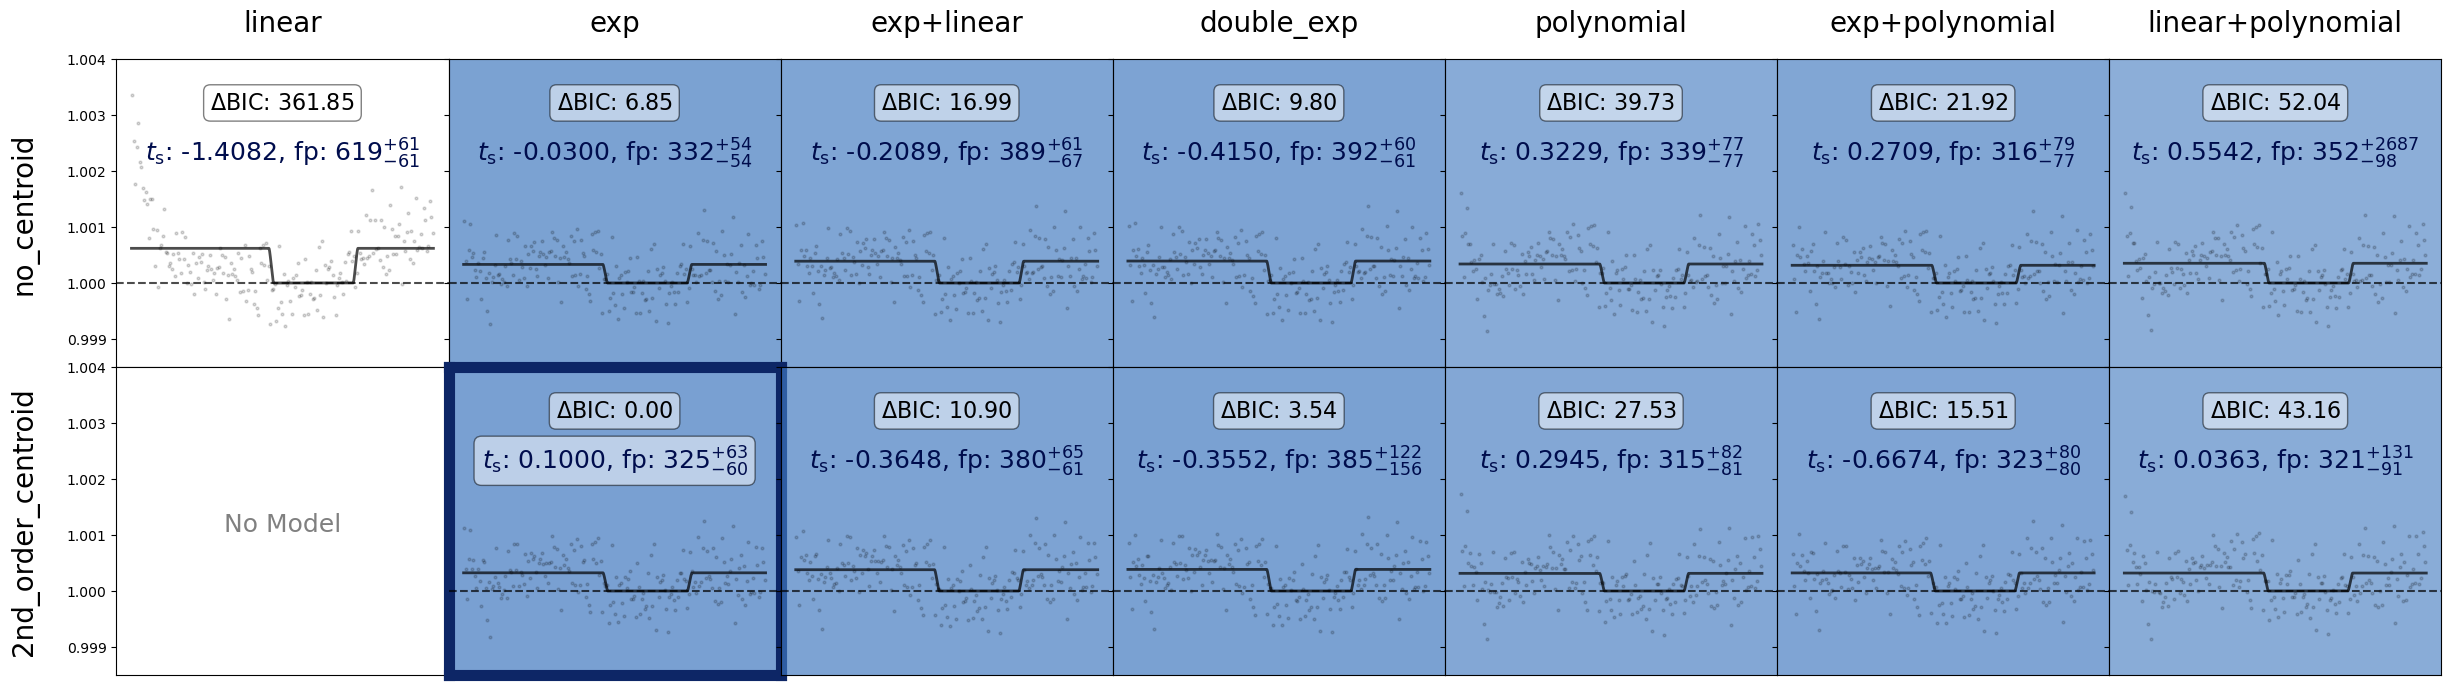

In [15]:
cols = ['linear','exp', 'exp+linear', 'double_exp', 'polynomial', 'exp+polynomial', 'linear+polynomial'] #'linear',
rows = ['no_centroid', '2nd_order_centroid'] #'1st_order_centroid', 
minflux = 0.9985
maxflux = 1.004
color = 'blue'

fig, subplot_dict = create_subplot_names(rows, cols, minflux=minflux, maxflux=maxflux)

mode_list = list(subplot_dict.keys())

bic_values_dict = {}
t_s_dict = {model: [] for model in models}
t_s_errp_dict = {model: [] for model in models}
t_s_errm_dict = {model: [] for model in models}
fp_dict = {model: [] for model in models}
fp_errp_dict = {model: [] for model in models}
fp_errm_dict = {model: [] for model in models}
for model in models:
    bic_values_dict[model], t_s_dict[model], t_s_errp_dict[model], t_s_errm_dict[model], fp_dict[model], fp_errp_dict[model], fp_errm_dict[model] = parameters[model]['BIC']['value'], parameters[model]['t_s']['value'], parameters[model]['t_s']['plus_err'], parameters[model]['t_s']['minus_err'], parameters[model]['fp']['value'], parameters[model]['fp']['plus_err'], parameters[model]['fp']['minus_err']

bic_values_dict, min_bic_key = calculate_delta_bic(bic_values_dict)

print('bic_values_dict is ', bic_values_dict)
print('t_s_dict is ', t_s_dict)
print('fp_dict is ', fp_dict)

bic_colors_dict = assign_colors_to_bic(bic_values_dict)
colors = list((assign_colors_to_bic(bic_values_dict)).values())

detec = {}
astro = {}
residuals = {}
for model in models:
    if model == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+linear'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, c5, sigF], model)
    elif model == 'exp':
        t_s, fp, c1, c2, c3, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, sigF], model)
    elif model == 'linear':
        t_s, fp, c1, c2, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['linear'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, sigF], model)
    elif model == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['polynomial'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, sigF], model)
    elif model == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+polynomial'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF], model)
    elif model == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['linear+polynomial'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, c5, c6, sigF], model)
    elif model == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['double_exp'].values()]
        detec[model] = detec_model(time, [t_s, fp, c1, c2, c3, c4, sigF], model)
    elif model == 'linear+polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['linear+polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, c11, c12, sigF], 'linear+polynomial')
        detec[model] = detec1*detec2
    elif model == 'exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, sigF], 'exp')
        detec[model] = detec1*detec2
    elif model == 'exp+polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, c11, c12, c13, sigF], 'exp+polynomial')
        detec[model] = detec1*detec2
    elif model == 'exp+linear_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['exp+linear_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, c11, sigF], 'exp+linear')
        detec[model] = detec1*detec2
    elif model == 'polynomial_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['polynomial_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, sigF], 'polynomial')
        detec[model] = detec1*detec2
    elif model == 'double_exp_2nd_order_centroid':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, sigF, RMS, chi2, BIC, RMS2 = [param['value'] for param in parameters['double_exp_2nd_order_centroid'].values()]
        detec1 = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
        detec2 = detec_model(time, [t_s, fp, c7, c8, c9, c10, sigF], 'double_exp')
        detec[model] = detec1*detec2

    astro[model] = transit_model(time, t_s, fp)  
    residuals[model] = (aplev / detec[model]) - astro[model]

    if 'centroid' in model: 
        if model == min_bic_key:                            
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=(t_s_dict[model]-eclipse), fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model], min_subplot=True)
        else:
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model, bic=bic_values_dict[model], t_s=(t_s_dict[model]-eclipse), fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model])
    else:        
        if model == min_bic_key:                            
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model+'_no_centroid', bic=bic_values_dict[model], t_s=(t_s_dict[model]-eclipse), fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model], min_subplot=True)
        else:
            axes = plot_model(time, aplev, astro[model], detec[model], nbin = 200, axName=model+'_no_centroid', bic=bic_values_dict[model], t_s=(t_s_dict[model]-eclipse), fp=[fp_dict[model], fp_errp_dict[model], fp_errm_dict[model]], background_colors=bic_colors_dict[model])

plt.show()

## ADD TIME AXIS TO PLOTS

In [8]:
print(t_s_dict['exp_2nd_order_centroid'])
print(eclipse)
print((t_s_dict['exp_2nd_order_centroid'] - eclipse)*60)


2.3602571294799635
2.358589777140878
0.10004114034511957


ajouter axe x temps, nombre de points par bin
nbin = 1 cest lintervale entre deux points (11.1s)
1 bin = 1260 points (cadence 11.1s), time is 233 minutes
2 bins = 630 points each (11.1s), time is 116,55 min
12 bins = 105 points each (11.1s) time is 67.8 min (eclise duration)
3.5 bins = 366 points (11.1s) time is 67.8 min (eclise duration)


Mode linear_no_centroid plotted
here
Mode exp_no_centroid plotted
Mode exp+linear_no_centroid plotted
Mode exp+polynomial_no_centroid plotted
Mode linear+polynomial_no_centroid plotted
Mode polynomial_no_centroid plotted
Mode double_exp_no_centroid plotted
Mode exp_2nd_order_centroid plotted
Mode exp+polynomial_2nd_order_centroid plotted
Mode exp+linear_2nd_order_centroid plotted
Mode polynomial_2nd_order_centroid plotted
Mode linear+polynomial_2nd_order_centroid plotted
Mode double_exp_2nd_order_centroid plotted


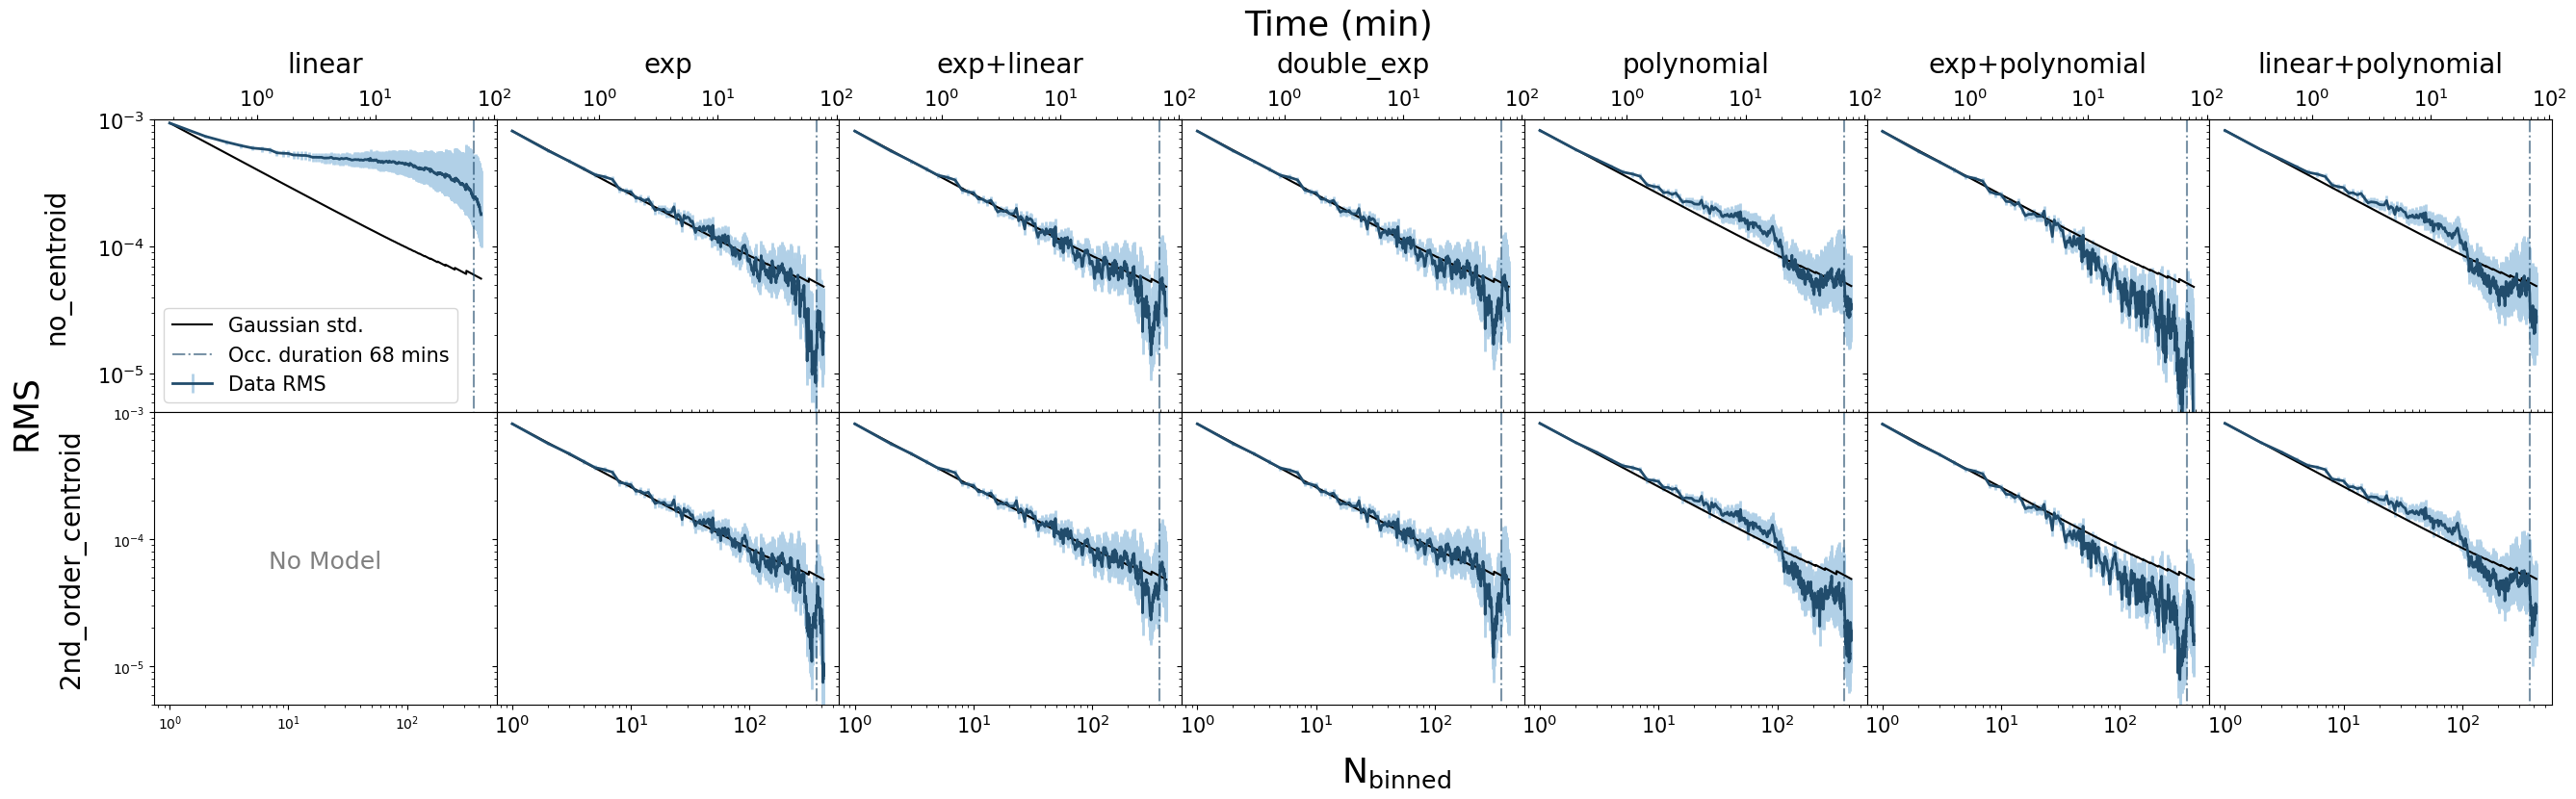

In [9]:
fig, subplot_dict = create_subplot_names(rows, cols, rednoisePlot=True)
mode_list = list(subplot_dict.keys())


def plot_rednoise(residuals, minbins, occDuration = None, fname=None, fontsize=10, axName=None, xAx=True):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="-", color='#214C6C', ecolor='#B1D0E7', capsize=0, linewidth=2, label="Data RMS")
    axes.plot(binsz, stderr, c='k', label="Gaussian std.")
    ylim = axes.get_ylim()
    #xlim = axes.get_xlim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        axes.vlines(occDuration, 10e-4, 0, color='#214C6C', ls='-.', alpha=0.6, label='Occ. duration 68 mins')
    axes.set_ylim(5.e-6, 1e-3)
    #axes.set_ylim(10e-5, 1e-3)
    #axes.set_ylim(ylim)

    # Add second x-axis on top showing time per bin
    cadence = 11.1  # seconds
    secax = axes.secondary_xaxis('top', functions=(lambda x: x * cadence / 60, lambda x: x * 60 / cadence))
    secax.tick_params(labelsize=fontsize)                        
    
    axes.xaxis.set_tick_params(labelsize=fontsize)
    axes.yaxis.set_tick_params(labelsize=fontsize)
    if xAx is False:
        secax.set_xticks([])

    
    # plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    # plt.ylabel('RMS', fontsize=fontsize)
    if axName == 'linear_no_centroid':
        axes.legend(loc='best', fontsize=fontsize)
        print('here')
    
    if fname is not None:
        plt.savefig(fname)

    return axes

for model in models:
    if 'centroid' in model: 
        axes = plot_rednoise(residuals[model], 3, fontsize=15, axName=model, occDuration=366.4864864864865, xAx=False)
    else:
        axes = plot_rednoise(residuals[model], 3, fontsize=15, axName=model+'_no_centroid', occDuration=366.4864864864865)

fig.supylabel("RMS", fontsize=26)
fig.supxlabel(r"N$_{\rm binned}$", fontsize=26)
fig.subplots_adjust(left=0.07, bottom=0.12)  # Tune as needed
fig.text(0.48, 0.99, 'Time (min)', ha='center', fontsize=26)
plt.savefig('plots/combined_plot_rednoise_e1_linear.pdf', bbox_inches='tight')

plt.show()

# dont forget that minBin refers to min number of points per bin and binSz 
# 1.13*60*60/11.1
# nb of points in occ dur: 366.4864864864865
# 1260 points total

In [41]:
# fp
weight_fp = []
fp_w = []
fp_weighted = []
var_fp = []

# t_s
weight_ts = []
t_s_w = []
t_s_weighted = []
t_s_var = []

for model in models:
    weight_fp.append(fp_errp_dict[model] + np.abs(fp_errm_dict[model]))
    fp_w.append(fp_dict[model])

    weight_ts.append((t_s_errp_dict[model] + np.abs(t_s_errm_dict[model]))*60)
    t_s_w.append((t_s_dict[model] - eclipse)*60)

# weighted average fp
weight_fp = np.array(weight_fp)
fp_w = np.array(fp_w)

fp_weighted = np.average(fp_w, weights=weight_fp)
fp_weighted = np.array(fp_weighted)

var_fp = ((np.sum(fp_w**2 * weight_fp)/np.sum(weight_fp)) - fp_weighted**2)*(len(fp_w)/(len(fp_w)-1))  # unbiased variance
std_err_fp = np.sqrt(var_fp/len(fp_w))

print('Weighted average of fp:', fp_weighted*1e6, '+/-',std_err_fp*1e6 ,'ppm')

# weighted average ts
weight_ts = np.array(weight_ts)
t_s_w = np.array(t_s_w)

t_s_weighted = np.average(t_s_w, weights=weight_ts)
t_s_weighted = np.array(t_s_weighted)

t_s_var = ((np.sum(t_s_w**2 * weight_ts)/np.sum(weight_ts)) - t_s_weighted**2)*(len(t_s_w)/(len(t_s_w)-1))  # unbiased variance
std_err_t_s = np.sqrt(t_s_var/len(t_s_w))
print('Weighted average of t_s:', t_s_weighted, '+/-',std_err_t_s, 'minutes')

textfile = 'MCMC_results/all_eclipses_weighted_mean_results.txt'
with open(textfile, 'a') as f:
    f.write('Weighted mean E1\n')
    f.write('fp = '+str(fp_weighted*1e6)+' +/- '+str(std_err_fp*1e6)+' ppm\n')
    f.write('t_s = '+str(t_s_weighted)+' +/- '+str(std_err_t_s)+' minutes\n')
    f.close()


Weighted average of fp: 357.3254595160986 +/- 13.57139753521943 ppm
Weighted average of t_s: -0.09453235289854717 +/- 0.11980057362147242 minutes


In [28]:
print((t_s_weighted),(weight_ts))

[[-1.40824875885877], [-0.029990839169942163], [-0.20891553843642718], [0.27093259278596626], [0.5541516962463167], [0.3229347356489143], [-0.41495770936522014], [0.10004114034511957], [-0.6673816542823641], [-0.3647540045824904], [0.29454812780267403], [0.03628420353891215], [-0.3551642535998756]] [1.03643721 5.88507928 1.65859572 1.64690325 1.64400448 1.59404297
 1.55655515 1.70853737 1.7035006  1.58812875 1.60766537 1.71387664
 1.6909379 ]


bin de 1 means 1 point par bin